In [1]:
from classes import *
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

import geopandas as gpd
from shapely.geometry import Polygon as ShapelyPolygon
import pandas as pd # Used to Export Data to csv format, so long processing steps only have to be done once
import json

from os import path

In [2]:
data1_path = "data/Polygons_no_mountains.geojson"
data2_path = "data/Polygons_with_mountains.geojson"
data3_path = "data/swissnames_points_json_export.geojson"

json_files = [(data1_path, "Gemeinden_ohne_Berge"),
(data2_path, "Gemeinden_mit_Berge"),
(data3_path, "Swissnames_Points")]


## Read in Data (Marek)

Short description what happens and how

In [3]:
data = process_json_file(json_files)

## Preprocessing (Sebi)

Samesame

In [4]:
polygon_data = Polygon_Data(data['Gemeinden_mit_Berge'],data['Gemeinden_ohne_Berge'])

In [5]:
polygon_data.remove_unique_entries()

10 unique objects removed from municipalities_polygons:
Polygon Zwieselberg consisting of 6 points BFS_Nr=947
Polygon Wangenried consisting of 6 points BFS_Nr=993
Polygon Escholzmatt-Marbach consisting of 23 points BFS_Nr=1010
Polygon Lüterswil-Gächliwil consisting of 9 points BFS_Nr=2456
Polygon Bergün Filisur consisting of 36 points BFS_Nr=3544
Polygon Turgi consisting of 9 points BFS_Nr=4042
Polygon Novaggio consisting of 11 points BFS_Nr=5207
Polygon Törbel consisting of 11 points BFS_Nr=6296
Polygon Beurnevésin consisting of 7 points BFS_Nr=6773
Polygon Bonfol consisting of 9 points BFS_Nr=6775

16 unique objects removed from muns_only_vegetation_area_polygons:
Polygon Valsot consisting of 43 points BFS_Nr=3764
Polygon Ponte Capriasca consisting of 6 points BFS_Nr=5212
Polygon Rüeggisberg consisting of 17 points BFS_Nr=880
Polygon Zuoz consisting of 8 points BFS_Nr=3791
Polygon Samedan consisting of 14 points BFS_Nr=3786
Polygon Madulain consisting of 8 points BFS_Nr=3783
Polygon 

In [6]:
# Polygon Intersection
municipalities_mountain_area = polygon_data.apply_difference()

In [7]:
point_data = data['Swissnames_Points']
len(point_data)

329322

In [8]:
# Flatten Lists and remove polygons smaller than 100 m^2 
municipalities_mountain_area_flattened_list = [item for sublist in municipalities_mountain_area for item in sublist if item.area() >= 100]
len(municipalities_mountain_area_flattened_list)

2894

In [9]:
# The function returns a list containing polygon id, point id, point name and point type
# !!!Warning: Long Processing Time!!!


#result_only_veg = point_polygon_matching(point_data,polygon_data.cleaned_mun_only_vegetation_polys)

#result_full_polys = point_polygon_matching(point_data,polygon_data.cleaned_mun_polys)

#result_mountain_polys = point_polygon_matching(point_data,municipalities_mountain_area_flattened_list)


In [10]:

# Save DataFrame to CSV file
#result_only_veg_df = pd.DataFrame(result_only_veg)
#result_only_veg_df.to_csv('data/matched_points_vegetation.csv', index=False)

#result_mountain_polys_df = pd.DataFrame(result_mountain_polys)
#result_mountain_polys_df.to_csv('data/matched_points_mountain.csv', index=False)

#result_full_polys_df = pd.DataFrame(result_full_polys)
#result_full_polys_df.to_csv('data/matched_points_full.csv', index=False)

In [11]:
# Read CSV
vegetation = pd.read_csv('data/matched_points_vegetation.csv')
mountains = pd.read_csv('data/matched_points_mountain.csv')
full = pd.read_csv('data/matched_points_full.csv')

# Rename Columns
vegetation.rename(columns={'0': 'polygon_id', '1': 'point_id', '2': 'name', '3': 'objektart'}, inplace=True)
mountains.rename(columns={'0': 'polygon_id', '1': 'point_id', '2': 'name', '3': 'objektart'}, inplace=True)
full.rename(columns={'0': 'polygon_id', '1': 'point_id', '2': 'name', '3': 'objektart'}, inplace=True)

        
# Grouping and counting for the vegetation dataframe
vegetation_grouped = vegetation.groupby(['polygon_id', 'objektart']).size().reset_index(name='point_count')

# Grouping and counting for the mountains dataframe
mountains_grouped = mountains.groupby(['polygon_id', 'objektart']).size().reset_index(name='point_count')

# Grouping and counting for the full dataframe
full_grouped = full.groupby(['polygon_id', 'objektart']).size().reset_index(name='point_count')


print(vegetation_grouped)

      polygon_id objektart  point_count
0              1  Bergname            2
1              1  Flurname          108
2              2  Bergname            1
3              2  Flurname          193
4              3  Bergname            1
...          ...       ...          ...
3418        6809  Flurname          544
3419        6810  Bergname            5
3420        6810  Flurname          461
3421        6811  Bergname            1
3422        6811  Flurname          142

[3423 rows x 3 columns]


In [12]:
#join the dataframes with the two additional attributes with the polygons via the polygon_id
polygon_data.join_csv(full_grouped, vegetation_grouped, mountains_grouped)

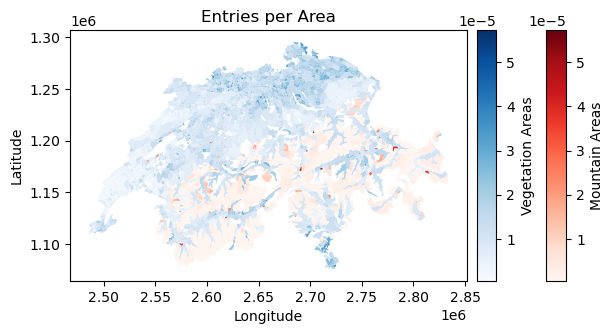

In [13]:
#create a map for both types of polygons (vegetation and mountain areas)
polygon_data.plot_poly_both()

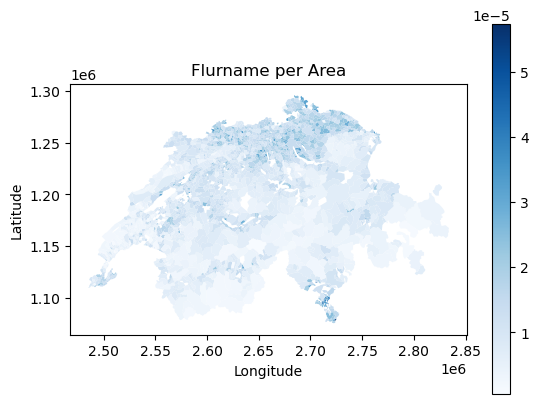

In [14]:
#create a map plot for the points in polygons with "Flurnamen" objektarten
polygon_data.plot_obj_flur()

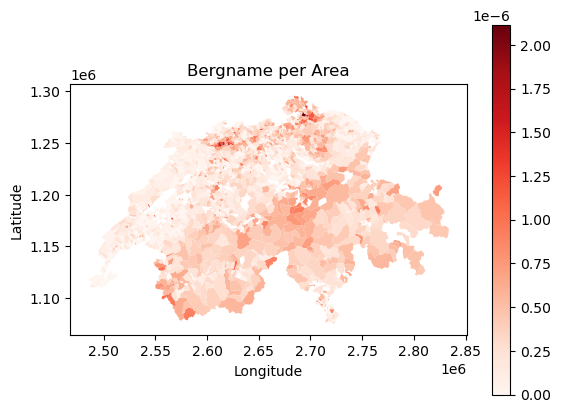

In [15]:
#create a map plot for the points in polygons with "Bergnamen" objektarten
polygon_data.plot_obj_berg()